<a href="https://colab.research.google.com/github/ifcb-utopia/plankton-CNN-DEMO/blob/main/5_Group_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification of 5 Groups of Phytoplankton Image Data**

This Notebook provides a framework ML model that trains to classify five different phytoplankton species from images

# Background

Phytoplankton are microscopic plants that cover the whole ocean. They play a vital role in the health of the waters: supplying the marine food web, generating oxygen by photosynthesis, removing carbon dioxide out of the oceans surface, etc.

Beyond providing insight into the health of the planet overall, the *type* of phytoplankton is often important to researchers. There are thousands of types of phytoplankton, and so being able to identify types present in specific ecosystems can be crucially important.

The Imaging FlowCytoBot (IFCB) is a device that captures high resolution images of ocean particles. Identifying all types of phytoplankton accurately presents a monumental challenge, but this notebook aims to provide a simple framework using a machine learning (ML) image classification model on just five common types of phytoplankton.

In this notebook, there are 5 types of phytoplankton: chaetoceros (chae), dinoflagellates (dino), euglenoids (eug), cryptophytes (crypt), oxytoxum (oxy). We have 1000 human-manually labelled images from each type, and we're building a model to automatically label the type of phytoplankton from an IFCB image.

# Steps

First, we read in the 5,000 images from Google Drive that have been manually labeled. There are two data streams read in: a csv file with each row containing metadata for ALL images collected, and a folder of plankton images in .png format. 

Next, we prepare the image data by rescaling/resizing/etc, and then convert to a 4D array for processing and training the neutral network.

After training, we evaluate the network's performance. With this model, we have achieved 90% accuracy.

# Acknowledgements:

Function for image pre-processing `preprocess_input` is from E. Culhane

Machine Learning Model setup and training code are from the example:
https://keras.io/examples/vision/mnist_convnet/

A better documented version of that script can be found here:
https://colab.research.google.com/drive/1gqWwrWXmFROq5X9b4_aIuQa-3utla1Nh?usp=sharing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Ds0GNR9uNKWBy49_sLARCbn7hIAY9lfh?authuser=1#scrollTo=FpZyQpk5IzGh)



## Import Statements

Here's a complete cell of all the import statements used in this notebook. Note that this notebook also writes import statements as we go

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
from glob import glob
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Google Drive Configuration

Here we specify the pathways to the data stored on the UTOPIA folder in Google Drive

In [5]:
DATA_PATH = 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/'
SAMPLE_DATA_PATH = 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/'
OUTPUT_PATH = 'gdrive/MyDrive/UTOPIA/Outputs'

In [6]:
# Sets the home directory as gdrive. Seems to already be the default, but we
# mount this just to be extra clear
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Reading Metadata Image .csv file by row

Each row of the metadata has two columns: the file name of the image and the type of phytoplankton that the image represents

In [11]:
import pandas as pd # Used for dealing with labelled databases

# Each row of the .csv file corresponds to a "manually" labeled image in the 
# dataset
csv_file = 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/five_groups_labels.csv'

# Define dataframe as the entire .csv file (all the rows are images)
df = pd.read_csv(csv_file)

In [ ]:
# Checks the first five rows
df.head()

,file_name,label
0,D20160519T234121_IFCB107_00018.png,chae
1,D20160519T234121_IFCB107_00137.png,chae
2,D20160519T234121_IFCB107_00156.png,chae
3,D20160519T234121_IFCB107_00175.png,chae
4,D20160519T234121_IFCB107_00378.png,chae


In [ ]:
# Checks the size of the data frame (# of images, attributes per image), should
# be (5000, 2)
df.shape

(5000, 2)

In [ ]:
# Displays the frequency of the 5 types of phytoplankton 
# stored in the metadata (should be 1000 each)
df.label.unique()
df.label.value_counts()

chae     1000
crypt    1000
dino     1000
eug      1000
oxy      1000
Name: label, dtype: int64

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

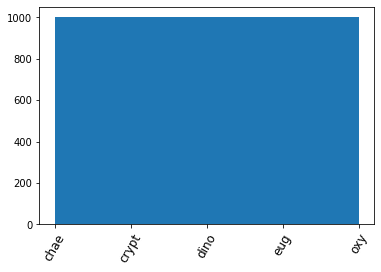

In [ ]:
import matplotlib.pyplot as plt # For plotting data

# Column in dataframe "label" represents type of phytoplankton

# Plot distribution of types (coarse taxonomic resolution)
df.label.hist(bins=5, grid=0, xlabelsize = 12)  # Bins = 5 unique types of plankton
plt.xticks(rotation = 60)

# Should have 5 categories, all with 1000 images

## Read PNG images

We extract the .png files from the 'five_groups' folder

In [ ]:
from glob import glob # For regular expressions
png_files_gdrive = glob('gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/*.png')

In [ ]:
# Tells us the relative path of the first 5 .png images
png_files_gdrive[0:5]

['gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/D20160521T164054_IFCB107_00189.png',
 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/D20160521T164054_IFCB107_02409.png',
 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/D20160521T164054_IFCB107_00087.png',
 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/D20160521T164054_IFCB107_02453.png',
 'gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/D20160521T164054_IFCB107_02425.png']

In [ ]:
# Should be exactly 5000 .png images files (corresponds to the 5000 images in
# the metadata)
len(png_files_gdrive)

5000

Now, we combine the image names in the metadata with the .png relative paths of all the 5000 images

In [ ]:
'''
  Create a dataframe with three cols/attributes: 
  png_name (called 'file_name' in the metadata), label, png_path

  Example: 
    file_name: D20160521T164054_IFCB107_05202.png
    label: oxy
    png_path: gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/five_groups/D20160521T164054_IFCB107_05202.png
'''

# Adds a column at the right of the dataset that stores the relative file path 
# of each image
df['png_path'] = df['file_name'].apply(lambda row : os.path.join(SAMPLE_DATA_PATH, row))

In [ ]:
df # Verifies the correct data frame (should be 3 columns: [file_name, label, png_path])

,file_name,label,png_path
0,D20160519T234121_IFCB107_00018.png,chae,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
1,D20160519T234121_IFCB107_00137.png,chae,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
2,D20160519T234121_IFCB107_00156.png,chae,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
3,D20160519T234121_IFCB107_00175.png,chae,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4,D20160519T234121_IFCB107_00378.png,chae,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
...,...,...,...
4995,D20160521T164054_IFCB107_03214.png,oxy,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4996,D20160521T164054_IFCB107_03437.png,oxy,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4997,D20160521T164054_IFCB107_04189.png,oxy,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4998,D20160521T164054_IFCB107_04221.png,oxy,gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...


## Preprocessing Image Inputs

This function prepares images for the ML classification network by squarring and padding images taken as input

This function was directly copied from Emmett's data_io_function_library. A full copy of his classification program can be found at:
https://drive.google.com/file/d/1xlVvZ-xy7RxfrGUbwAmERZ3rxqoUsq1f/view?usp=sharing

In [ ]:
'''
  Squares and pads images to 128x128 pixels to prepare them for the neural network
'''

import cv2

def preprocess_input(image):

    fixed_size = 128 # Final image should be 128 x 128
    image_size = image.shape[:2] # Gets the (y_dim, x_dim) for each image

    # The ratio needed to make the longest side of the image 128 pixels
    ratio = float(fixed_size)/max(image_size)

    # Calculates the new size by multiplying each dimension by the ratio
    new_size = tuple([int(x*ratio) for x in image_size])

    # Resizes the image to the new size
    img = cv2.resize(image, (new_size[1], new_size[0]))

    # Calculates the possible padding needed for the x and y dimensions
    delta_w = fixed_size - new_size[1]
    delta_h = fixed_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    # Makes a black border of 128x128 pixels around the image, so either
    # dimension less than 128 would be padded to 128
    color = [0, 0, 0] # RGB = 0,0,0 -> Black
    rescaled_image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return(rescaled_image)

## Preprocess Phytoplankton Images

Here we use the defined function above to preprocess the images of phytoplankton samples for the neural network. 

We save the attributes (dimensions, grayscale, etc.) of each image as a 4 dimensional array

In [12]:
# Holds just the indexed labelling of images in the sample
image_labels = df.label

image_labels # For verification

0       chae
1       chae
2       chae
3       chae
4       chae
        ... 
4995     oxy
4996     oxy
4997     oxy
4998     oxy
4999     oxy
Name: label, Length: 5000, dtype: object

In [ ]:
# Verifies the proper full path for the images in the sample
filename = df['png_path']

filename

0       gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
1       gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
2       gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
3       gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4       gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
                              ...                        
4995    gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4996    gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4997    gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4998    gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
4999    gdrive/MyDrive/UTOPIA/Hisham/Example_dataset/f...
Name: png_path, Length: 5000, dtype: object

Text(0.5, 1.0, 'dino')

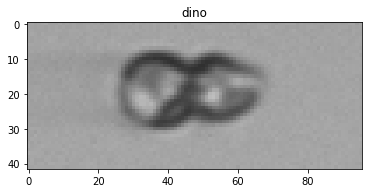

In [ ]:
# Displays an example image and label
image = cv2.imread(filename.iloc[2499]) # 2500th image
rescaled_image = preprocess_input(image)

# Prints image and then the label from the metadata
plt.figure()
plt.imshow(image)
plt.title(image_labels.iloc[2499])

In [ ]:
# Preprocesses ALL the images in the sample, and compiles all the images into a dataset
# NOTE: This function is the meat of the program, so it may take awhile (the 
# last run took 53 min).
dataset = []
for filename, label in zip(df['png_path'],image_labels):
  image = cv2.imread(filename)
  rescaled_image = preprocess_input(image)
  dataset.append(rescaled_image)

In [ ]:
len(dataset) # Should match the number of images in the sample

5000

In [ ]:
# Creates a stacked 4D array from the dataset
# dataset_4d = (# of Images, x dim = 128, y dim = 128, # of color inputs in RGB = 3)
dataset_4d = np.array(dataset)

In [ ]:
import numpy as np # For arrays (.npy is a numpy object)

# Saves the preprocessed images so we don't need to re-process every time
np.save(os.path.join(OUTPUT_PATH,"fivegroups_dataset_4d_10000.npy"),dataset_4d)

In [7]:
# Loads the data from the file
dataset_4d = np.load('/content/gdrive/MyDrive/UTOPIA/Outputs/fivegroups_dataset_4d_10000.npy')

Text(0.5, 1.0, 'dino')

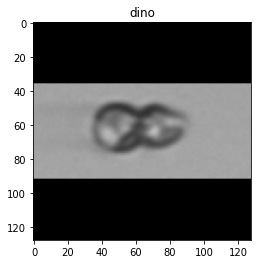

In [ ]:
# Example: Displays the image and classification of the 2500th phytoplankton 
#          collected in the sample
plt.figure()
plt.imshow(dataset_4d[2499])
plt.title(str(image_labels.iloc[2499]))

## Build the ML Model

Here we borrow from the MNIST model, and adapt that network to fit with the phytoplankton data.

We have to first process the data by dividing it into train/test and extract important parameters. Then we build the ML model using TensorFlow.

Note: The digit example model uses RGB images while the phytoplankton are grayscaled. We must remove that parameter before building the network.

In [8]:
# Model/Data Parameters
num_classes = 5 # 5 Types of Phytoplankton
input_shape = (128, 128, 1) # (128 x pixels, 128 y pixels, 1 grayscale num)

In [13]:
'''
  Converts class vectors to binary class matrices

  Example: If image_labels[34] = 'Diatom', then we would create an array
           [0, 0, 0, 1, 0], where the index 3 represents
           'Diatom' and a 1 classifies the image as such

'''
image_label_dummys = pd.get_dummies(image_labels)

image_label_dummys # Displays the classification

,chae,crypt,dino,eug,oxy
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
4995,0,0,0,0,1
4996,0,0,0,0,1
4997,0,0,0,0,1
4998,0,0,0,0,1


In [14]:
# Frequency distribution of the Phytoplankton labels in the sample
# Should be 1000 of each
image_labels.value_counts()

chae     1000
crypt    1000
dino     1000
eug      1000
oxy      1000
Name: label, dtype: int64

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

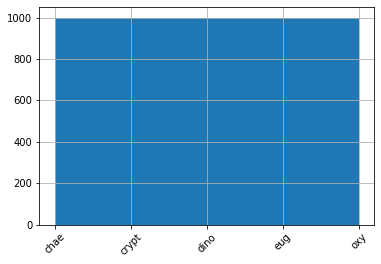

In [15]:
# Displays the distribution of Phytoplankton types graphically
image_labels.hist(bins=5) # 5 types of phytoplankton
plt.xticks(rotation = 45)

In [17]:
# Converts image to grayscale and not RGB -> Loses the last parameter
dataset_3d = dataset_4d[:,:,:,0] # Zeroes out the last parameter

# To compare
dataset_4d.shape
dataset_3d.shape

(5000, 128, 128)

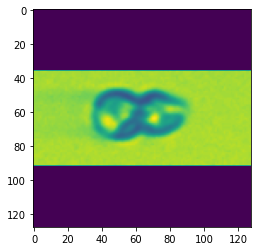

In [18]:
# Example: Shows the 2500th phytoplankton image in the sample, without the RGB 
#          parameters in dataset_4d (note: colors might look odd)
plt.imshow(dataset_3d[2499,])

In [19]:
'''
  Splits the data into training and testing data
  test_size = ratio of data that we use to evaluate model (1 - test_size is the ratio to train)
  random_state = seed for the random number generator
                 (ensures that multiple runthroughs have the same data initialization)
'''

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset_3d, image_label_dummys, test_size=0.33, random_state=42)

In [20]:
# x means input, should be (# Images, 128 x pixels, 128 y pixels)
print(x_train.shape)
print(x_test.shape)

# y means output, should be (# Images, # Classes = 5 Phytoplankton types)
print(y_train.shape)
print(y_test.shape)

(3350, 128, 128)
(1650, 128, 128)
(3350, 5)
(1650, 5)


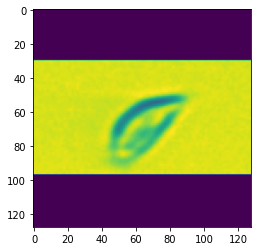

In [21]:
# Example of an input image to be trained by the network
plt.imshow(x_train[25,:,:])

In [22]:
'''

  Here we scale and verify the image measurements

  We want to convert the measurements in the input image to float32. 255 is
  the maximum value of a byte (the input feature's type before conversion), so we
  divide by 255 to scale the image between [0 and 1]. A value of 0-1 works well with
  the default learning rate and other hyperparameters in the model

  We also need to tune the images to have shape (128, 128, 1)
'''

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (128, 128, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (3350, 128, 128, 1)
3350 train samples
1650 test samples


The model has two convolutional layers, which get flattened into a 1D layer of neurons fed into a direct connected neural network

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), # 32 output filters
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), # 64 output filters
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5), # Each neuron has a 50% of turning off to prevent overfitting
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dropout (Dropout)           (None, 57600)             0

### Training the Model

Here we use TensorFlow's built-in operations to train the model with our data

In [23]:
x_train.shape # Verifying that our input data has the correct parameters

(3350, 128, 128, 1)

In [24]:
'''
  This cell trains the neural network with TensorFlow libraries and adjustable hyperparameters

  batch_size: number of images passed through training at one time (128)
  epochs: number of times the ENTIRE dataset will be passed through for training (15)
  validation_split: ratio of training data that will be used as a validation set for each epoch (10%)

  Note: Categorical Cross-entropy is a loss function that works well for single-label,
        multi-class categorization problems (like this one!)
'''

batch_size = 5
epochs = 8

# Training the model and checking accuracy on each epoch
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/8
536/536 [==============================] - 62s 115ms/step - loss: 0.9798 - accuracy: 0.6485 - val_loss: 0.6750 - val_accuracy: 0.7582
Epoch 2/8
536/536 [==============================] - 59s 111ms/step - loss: 0.5805 - accuracy: 0.8026 - val_loss: 0.5890 - val_accuracy: 0.7851
Epoch 3/8
536/536 [==============================] - 61s 115ms/step - loss: 0.4923 - accuracy: 0.8369 - val_loss: 0.5655 - val_accuracy: 0.8090
Epoch 4/8
536/536 [==============================] - 62s 115ms/step - loss: 0.4237 - accuracy: 0.8578 - val_loss: 0.5247 - val_accuracy: 0.8373
Epoch 5/8
536/536 [==============================] - 59s 111ms/step - loss: 0.3783 - accuracy: 0.8832 - val_loss: 0.5048 - val_accuracy: 0.8328
Epoch 6/8
536/536 [==============================] - 61s 114ms/step - loss: 0.3429 - accuracy: 0.8888 - val_loss: 0.4752 - val_accuracy: 0.8418
Epoch 7/8
536/536 [==============================] - 59s 111ms/step - loss: 0.2962 - accuracy: 0.9063 - val_loss: 0.5253 - val_accuracy:

### Checkpoint: Saving the Trained Model

Taken and modified from Emmett's code

Training the model takes time. Here we save the trained model so that we don't have to re-train on each open of our program

In [25]:
# Save model weights and structure from history object
model_json = model.to_json()
with open(os.path.join(OUTPUT_PATH,'Model_checkpoints',"model-test-cnn-5000.json"), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(OUTPUT_PATH,'Model_checkpoints',"model-test-cnn-5000.h5"))
print("Saved model to disk")


Saved model to disk


### Evaluate the Trained ML Model

Here we check the accuracy of our ML model for future predictions

In [26]:
score = model.evaluate(x_test, y_test, verbose=0) # Does not show on each epoch
print("Test loss:", score[0]) # Summation of errors in our model -> Tells us how well our model performs
print("Test accuracy:", score[1]) # Percentage of accurate predictions

Test loss: 0.4828459322452545
Test accuracy: 0.842424213886261


In [34]:
'''
  Here we want two lists: one that stores the correct count based on the metadata,
  and another that stores the count from training the network

  ytrain_classes: CORRECT classification from y_train
  classes: EXPERIMENTAL classification from y_pred
'''

y_pred = model.predict(x_train)
y_pred # Displays the predicted type of plankton based on index

classes = np.argmax(y_pred, axis = 1)
print(classes)

ytrain_classes = np.argmax(np.array(y_train), axis = 1)

[1 0 0 ... 3 3 4]


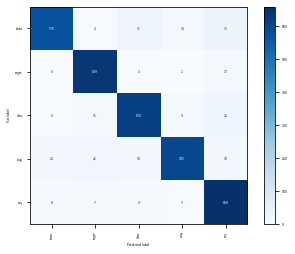

In [29]:
'''
  We create a Confusion Matrix to display the accuracy of our model visually

  A Confusion Matrix shows the contrasst between expected and actual classification.
  On the y-axis we have the true counts of classification, and the x-axis lies
  the predicted classification.

  If a count lies on the diagonal of the matrix, then it has been classified
  correctly. For example, from the matrix below we see that 619 dinoflagellates were
  correctly labelled as dinoflagellates. Ideally we want all the counts along the diagonal
  
  Any counts not on the diagonal represent a mistake. For example, from the matrix
  below we see that 14 chaetoceros were incorrectly predicted by our model as
  euglenoids. 
'''

from locale import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ytrain_classes, classes)
labels = list(y_train.columns)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.rc('font', size=3)
plt.show()